<a href="https://colab.research.google.com/github/imkunals726/DogNet/blob/master/DogIdentification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I had this file uploaded on my drive you can also do so and then mount the drive and access that file.

In [1]:
!cp "drive/My Drive/dog-breed-identification.zip" dog-breed-identification.zip

In [23]:
# !unzip dog-breed-identification.zip

In [3]:
import tensorflow as tf

In [1]:
EPOCHS = 12
BATCH_SIZE = 16 * 1 # this is 8 on TPU v3-8, it is 1 on CPU and GPU
LR_START = 0.00001
LR_MAX = 0.00005 * 1
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 4
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .9

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

NameError: ignored

Learning rate schedule: 1e-05 to 5e-05 to 2.91e-05


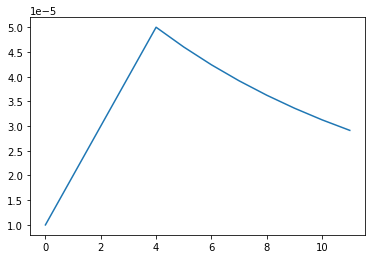

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [3]:
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import tensorflow.keras.layers as layers

img_info = pd.read_csv('labels.csv')
img_info['file_path'] = img_info['id'].apply(lambda file_name : f'train/{file_name}.jpg')

datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest',
      validation_split=0.2
      )

def get_dataset(subset='training'):

	dataset  = datagen.flow_from_dataframe(img_info, x_col = 'file_path', y_col = 'breed', 
												class_mode = 'categorical', subset = subset)

	return dataset




In [4]:
import tensorflow.keras.regularizers as regularizers
def create_pretrained_model():
  '''Its a very simple model'''
  pretrained_model = tf.keras.applications.Xception(weights='imagenet' , include_top = False)

  pretrained_model.trainable= True

  for layer in pretrained_model.layers[-10:]:
    layer.trainable=True

  
  
  x = layers.GlobalAveragePooling2D()(pretrained_model.output)
  x = layers.Dense(1024,activation = 'relu')(x)
  # x = layers.Dense(512,activation = 'relu')(x)
  x = layers.Dense(120,activation='softmax')(x)


  model = tf.keras.models.Model(inputs=pretrained_model.input, outputs=x)

  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
 
  return model

In [5]:




lrscheduler = tf.keras.callbacks.LearningRateScheduler(lrfn,verbose=1)
dognet = create_pretrained_model()


In [6]:
# dognet.summary()
train_dataset = get_dataset('training')
val_dataset = get_dataset('validation')



Found 8178 validated image filenames belonging to 120 classes.
Found 2044 validated image filenames belonging to 120 classes.


In [69]:

checkpoint_path = "simple_pretrained_model/cp_6.ckpt"


checkpoint = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor='loss', verbose=1,
    save_weights_only=True, mode='auto', save_freq='epoch'
)

# early_stopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=1)

# tf.keras.backend.set_value(dognet.optimizer.lr , 0.00001)
dognet.fit(train_dataset,epochs= 12, validation_data = val_dataset, callbacks = [checkpoint, lrscheduler])


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/12
256/256 [==============================] - ETA: 0s - loss: 4.6310 - accuracy: 0.0866
Epoch 00001: saving model to simple_pretrained_model/cp_6.ckpt
256/256 [==============================] - 241s 942ms/step - loss: 4.6310 - accuracy: 0.0866 - val_loss: 4.2381 - val_accuracy: 0.2916 - lr: 1.0000e-05

Epoch 00002: LearningRateScheduler reducing learning rate to 2e-05.
Epoch 2/12
256/256 [==============================] - ETA: 0s - loss: 3.1964 - accuracy: 0.5061
Epoch 00002: saving model to simple_pretrained_model/cp_6.ckpt
256/256 [==============================] - 230s 899ms/step - loss: 3.1964 - accuracy: 0.5061 - val_loss: 1.8103 - val_accuracy: 0.6639 - lr: 2.0000e-05

Epoch 00003: LearningRateScheduler reducing learning rate to 3.0000000000000004e-05.
Epoch 3/12
256/256 [==============================] - ETA: 0s - loss: 1.4119 - accuracy: 0.7196
Epoch 00003: saving model to simple_pretrained_model/cp_6.

In [7]:
classes = {index:breed for breed,index in train_dataset.class_indices.items()}
column_names = [classes[i] for i in range(120)]
# column_names

In [8]:
dognet.load_weights('simple_pretrained_model/cp_6.ckpt')

In [14]:
import os
import cv2
import pandas as pd

test_set = []
test_set_ids = []
for curImage in os.listdir('test'):
    test_set_ids.append(os.path.splitext(curImage)[0])
    curImage = cv2.imread('test/'+curImage)
    test_set.append(cv2.resize(curImage,(256, 256)))
    
# test_set = np.array(test_set, np.float32)/255.0

In [15]:

import numpy as np
test_set = np.array(test_set, np.float32)/255.0


In [16]:
predictions= dognet.predict(test_set)

In [17]:
predictions[0]

array([7.61149640e-05, 4.03646816e-04, 8.87534843e-05, 5.25339507e-04,
       2.75836210e-04, 2.64538743e-04, 1.15230221e-04, 5.10147875e-05,
       5.70853226e-05, 4.90865059e-05, 2.65754107e-03, 4.21965611e-04,
       4.68363505e-05, 1.30231827e-04, 2.24699805e-04, 2.22166505e-04,
       9.71377303e-05, 1.41287674e-04, 1.93973799e-04, 9.45409483e-05,
       1.27620925e-03, 3.71275906e-04, 9.21487444e-05, 3.13521974e-04,
       1.22253186e-04, 1.54674752e-04, 1.90953680e-04, 8.11134887e-05,
       2.01897812e-04, 1.88311329e-04, 3.38675251e-04, 2.19602394e-03,
       1.76915468e-03, 4.24110680e-04, 1.11228065e-03, 6.01794012e-03,
       7.80688861e-05, 3.65424290e-04, 3.73947551e-05, 1.20010183e-04,
       1.36439223e-03, 6.33250602e-05, 1.51812885e-04, 1.99394111e-04,
       2.70357385e-04, 1.38818636e-04, 2.63102720e-05, 1.34666276e-04,
       1.75960813e-04, 9.12219984e-04, 4.31861845e-04, 6.23479893e-04,
       7.08411331e-04, 1.29565087e-04, 3.56726814e-04, 8.42990048e-05,
      

In [55]:
len(test_set_ids)

10357

In [18]:
pred_df = pd.DataFrame(test_set_ids, columns = ['id'])

In [19]:
for col in column_names:
  pred_df[col] = 0
pred_df.loc[~pred_df['id'].isnull(),column_names] = predictions
pred_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,d524e1319b967c4e111b2ff4c75c5959,0.000076,0.000404,0.000089,0.000525,0.000276,0.000265,0.000115,0.000051,0.000057,4.908651e-05,2.657541e-03,4.219656e-04,4.683635e-05,1.302318e-04,2.246998e-04,2.221665e-04,0.000097,0.000141,0.000194,0.000095,0.001276,0.000371,0.000092,0.000314,1.222532e-04,0.000155,0.000191,0.000081,0.000202,0.000188,0.000339,2.196024e-03,0.001769,0.000424,0.001112,6.017940e-03,0.000078,0.000365,0.000037,...,0.000177,0.000121,5.872979e-04,0.000823,7.131631e-05,0.000431,0.000026,0.000611,0.000040,0.000225,0.000128,0.000087,5.923606e-04,2.640267e-04,0.000524,0.000351,0.000140,0.001279,0.000409,0.000097,5.165861e-04,0.000143,0.000103,0.000433,0.000099,0.388777,0.000108,0.000465,0.004559,0.001281,0.062163,0.000154,1.482560e-04,2.110794e-04,0.000395,1.923424e-04,0.000259,0.000404,0.000440,0.000204
1,36939316bd5dc74df7e0c33e76074408,0.000188,0.000240,0.000078,0.000375,0.000536,0.000048,0.000254,0.000087,0.000209,8.434132e-04,1.137588e-02,5.018630e-05,4.066187e-05,5.944302e-04,2.003692e-05,1.146489e-04,0.000066,0.000137,0.005185,0.000430,0.000505,0.003948,0.000779,0.000839,1.025260e-03,0.000253,0.011838,0.001041,0.000326,0.034704,0.000296,1.679254e-02,0.002783,0.000141,0.000123,1.428862e-03,0.000073,0.000590,0.000214,...,0.000208,0.000330,2.396126e-03,0.000316,3.626364e-05,0.000790,0.000078,0.004309,0.002427,0.000085,0.000048,0.000080,7.398234e-05,8.312361e-04,0.006995,0.000529,0.023190,0.000098,0.119311,0.000117,2.192256e-03,0.004838,0.000585,0.062605,0.007494,0.000428,0.001357,0.000063,0.000098,0.000536,0.000465,0.003673,1.390668e-04,2.600399e-03,0.000580,2.293316e-04,0.389565,0.000234,0.075537,0.000412
2,510a2f5eb6a0f513e2f9c2eb7545e10b,0.000435,0.000011,0.000003,0.000001,0.000008,0.000002,0.000004,0.000010,0.000002,6.701845e-07,4.834921e-07,4.584125e-07,6.459808e-07,9.728797e-07,4.947200e-07,6.179966e-07,0.000005,0.000004,0.000002,0.000001,0.800992,0.000011,0.000010,0.118827,1.868089e-07,0.000011,0.027552,0.000005,0.000006,0.000004,0.000081,7.556085e-07,0.000004,0.000006,0.000003,2.351452e-07,0.000001,0.000004,0.000008,...,0.000014,0.000018,8.258077e-07,0.000001,1.575841e-07,0.000005,0.000002,0.000007,0.000005,0.000001,0.000002,0.000005,1.789054e-07,5.564833e-07,0.000004,0.000177,0.001207,0.000004,0.000001,0.000008,2.765133e-07,0.000002,0.000004,0.000017,0.000024,0.000018,0.000026,0.000005,0.000107,0.000073,0.000002,0.000001,1.706393e-07,3.492984e-07,0.000001,7.493962e-08,0.000002,0.000012,0.000006,0.000005
3,b9e559b5221526b613a55512d5f2cb60,0.000140,0.000412,0.000215,0.000605,0.007185,0.013111,0.000175,0.001414,0.004755,2.169921e-02,1.460239e-04,2.026456e-03,3.512759e-04,5.704058e-03,1.503301e-04,6.246829e-02,0.008161,0.000775,0.001980,0.464053,0.000858,0.005716,0.000364,0.003618,1.306330e-03,0.000473,0.000628,0.035977,0.000776,0.002455,0.000339,9.221053e-04,0.003686,0.015194,0.000289,1.442507e-04,0.000244,0.000387,0.000253

In [20]:
pred_df.to_csv('dognet_preds.csv', index=False)

In [21]:
!zip dognet.zip simple_pretrained_model/*


updating: simple_pretrained_model/checkpoint (deflated 39%)
updating: simple_pretrained_model/cp2.ckpt.data-00000-of-00002 (deflated 90%)
updating: simple_pretrained_model/cp2.ckpt.data-00001-of-00002 (deflated 8%)
updating: simple_pretrained_model/cp2.ckpt.index (deflated 81%)
updating: simple_pretrained_model/cp3.ckpt.data-00000-of-00002 (deflated 90%)
updating: simple_pretrained_model/cp3.ckpt.data-00001-of-00002 (deflated 8%)
updating: simple_pretrained_model/cp3.ckpt.index (deflated 81%)
updating: simple_pretrained_model/cp4.ckpt.data-00000-of-00002 (deflated 90%)
updating: simple_pretrained_model/cp4.ckpt.data-00001-of-00002 (deflated 8%)
updating: simple_pretrained_model/cp4.ckpt.index (deflated 81%)
updating: simple_pretrained_model/cp5.ckpt.data-00000-of-00002 (deflated 90%)
updating: simple_pretrained_model/cp5.ckpt.data-00001-of-00002 (deflated 8%)
updating: simple_pretrained_model/cp5.ckpt.index (deflated 81%)
  adding: simple_pretrained_model/cp_6.ckpt.data-00000-of-00002 

In [22]:
!cp dognet.zip "drive/My Drive/"